In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'MOS'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-06-30,2440,-1919,521,250,2367,604,1580,5189,1793,...,750,13,1,1923,3013,7048,796,-214,375.6,2014-08-04
1,2014-09-30,2251,-1836,415,207,2971,574,1472,5660,1741,...,762,0,41,1549,3774,7511,357,-188,375.6,2014-11-04
2,2014-12-31,2379,-1800,579,354,2375,754,1718,5216,1807,...,797,14,41,1597,3778,7580,342,-252,375.6,2015-02-21
3,2015-03-31,2139,-1720,419,296,2517,661,1523,5251,1687,...,707,10,41,1620,3775,7440,729,-230,360.3,2015-05-05
4,2015-06-30,2488,-1880,608,390,2210,627,1612,5100,1710,...,858,27,57,1882,3762,7640,603,-227,360.3,2015-08-04


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-06-30,2023-08-04,333.2,3394,-2823,571,366,626,1222,3149,...,0,23140,1826,229,970,4840,2423,10735,1073,-310
37,2023-09-30,2023-11-04,333.2,3548,-3139,410,-13,591,1399,2453,...,0,22654,1706,300,955,4696,2402,10604,647,-412
38,2023-12-31,2024-02-21,333.2,3150,-2590,560,368,349,1269,2523,...,0,23033,1567,400,130,3874,3232,10743,538,-359
39,2024-03-31,2024-04-29,323.5,2679,-2280,399,19,336,1212,2603,...,0,22873,1586,267,128,4020,3221,10710,-80,-383
40,2024-06-30,2024-08-05,321.2,2816,-2422,394,-173,322,1285,2554,...,0,22566,1319,881,125,4119,3194,10736,847,-334


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-06-30,2023-08-04,333.2,3394,-2823,571,366,626,1222,3149,...,23140,1826,229,970,4840,2423,10735,1073,-310,1
37,2023-09-30,2023-11-04,333.2,3548,-3139,410,-13,591,1399,2453,...,22654,1706,300,955,4696,2402,10604,647,-412,1
38,2023-12-31,2024-02-21,333.2,3150,-2590,560,368,349,1269,2523,...,23033,1567,400,130,3874,3232,10743,538,-359,1
39,2024-03-31,2024-04-29,323.5,2679,-2280,399,19,336,1212,2603,...,22873,1586,267,128,4020,3221,10710,-80,-383,1
40,2024-06-30,2024-08-05,321.2,2816,-2422,394,-173,322,1285,2554,...,22566,1319,881,125,4119,3194,10736,847,-334,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-06-30,2023-08-04,333.2,3394.0,-2823.0,571.0,366.0,626.0,1222.0,3149.0,...,23140.0,1826.0,229.0,970.0,4840.0,2423.0,10735.0,1073.0,-310.0,1
37,2023-09-30,2023-11-04,333.2,3548.0,-3139.0,410.0,-13.0,591.0,1399.0,2453.0,...,22654.0,1706.0,300.0,955.0,4696.0,2402.0,10604.0,647.0,-412.0,1
38,2023-12-31,2024-02-21,333.2,3150.0,-2590.0,560.0,368.0,349.0,1269.0,2523.0,...,23033.0,1567.0,400.0,130.0,3874.0,3232.0,10743.0,538.0,-359.0,1
39,2024-03-31,2024-04-29,323.5,2679.0,-2280.0,399.0,19.0,336.0,1212.0,2603.0,...,22873.0,1586.0,267.0,128.0,4020.0,3221.0,10710.0,-80.0,-383.0,1
40,2024-06-30,2024-08-05,321.2,2816.0,-2422.0,394.0,-173.0,322.0,1285.0,2554.0,...,22566.0,1319.0,881.0,125.0,4119.0,3194.0,10736.0,847.0,-334.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-08-04,38.219933,2014-06-30,2440.0,0.0,29.941427,375.6,0.0,0.0,2367.0,...,0.614737,0.385263,0.0,0.0,0.0,0.0,0.213525,0.102459,0.0,0.0
1,2014-08-11,38.360306,2014-06-30,2440.0,0.0,29.941427,375.6,0.0,0.0,2367.0,...,0.614737,0.385263,0.0,0.0,0.0,0.0,0.213525,0.102459,0.0,0.0
2,2014-08-18,39.202675,2014-06-30,2440.0,0.0,29.941427,375.6,0.0,0.0,2367.0,...,0.614737,0.385263,0.0,0.0,0.0,0.0,0.213525,0.102459,0.0,0.0
3,2014-08-25,39.442173,2014-06-30,2440.0,0.0,29.941427,375.6,0.0,0.0,2367.0,...,0.614737,0.385263,0.0,0.0,0.0,0.0,0.213525,0.102459,0.0,0.0
4,2014-09-01,39.029243,2014-06-30,2440.0,0.0,29.941427,375.6,0.0,0.0,2367.0,...,0.614737,0.385263,0.0,0.0,0.0,0.0,0.213525,0.102459,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-08-04,38.219933,2014-06-30,2440.0,0.0,29.941427,375.6,0.0,0.0,2367.0,...,0.0,0.213525,0.102459,0.0,0.0,inf,1.276490,inf,inf,inf
1,2014-08-11,38.360306,2014-06-30,2440.0,0.0,29.941427,375.6,0.0,0.0,2367.0,...,0.0,0.213525,0.102459,0.0,0.0,inf,1.281178,inf,inf,inf
2,2014-08-18,39.202675,2014-06-30,2440.0,0.0,29.941427,375.6,0.0,0.0,2367.0,...,0.0,0.213525,0.102459,0.0,0.0,inf,1.309312,inf,inf,inf
3,2014-08-25,39.442173,2014-06-30,2440.0,0.0,29.941427,375.6,0.0,0.0,2367.0,...,0.0,0.213525,0.102459,0.0,0.0,inf,1.317311,inf,inf,inf
4,2014-09-01,39.029243,2014-06-30,2440.0,0.0,29.941427,375.6,0.0,0.0,2367.0,...,0.0,0.213525,0.102459,0.0,0.0,inf,1.303520,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

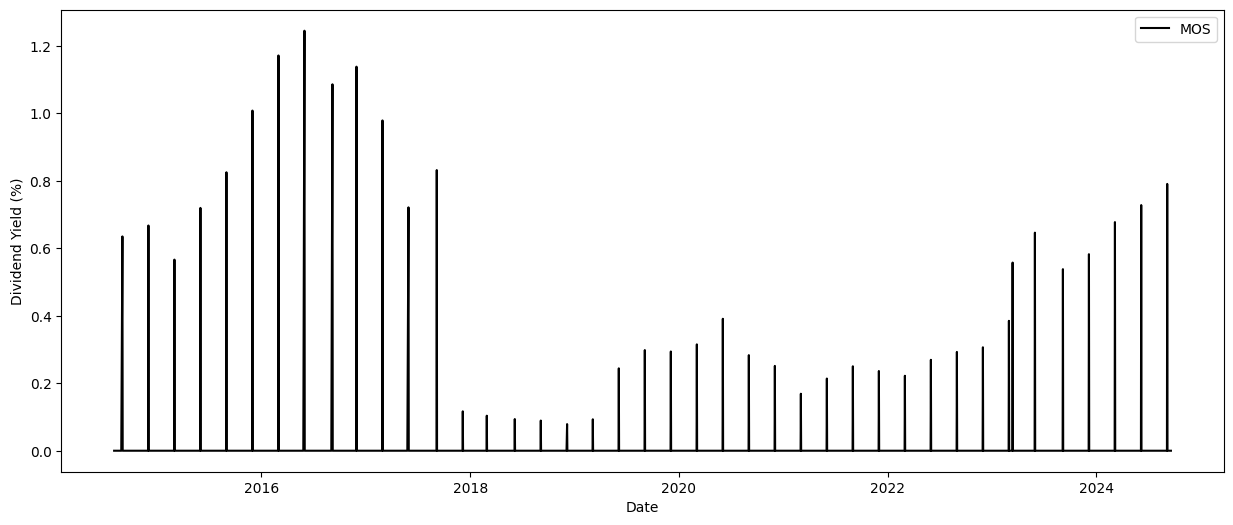

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


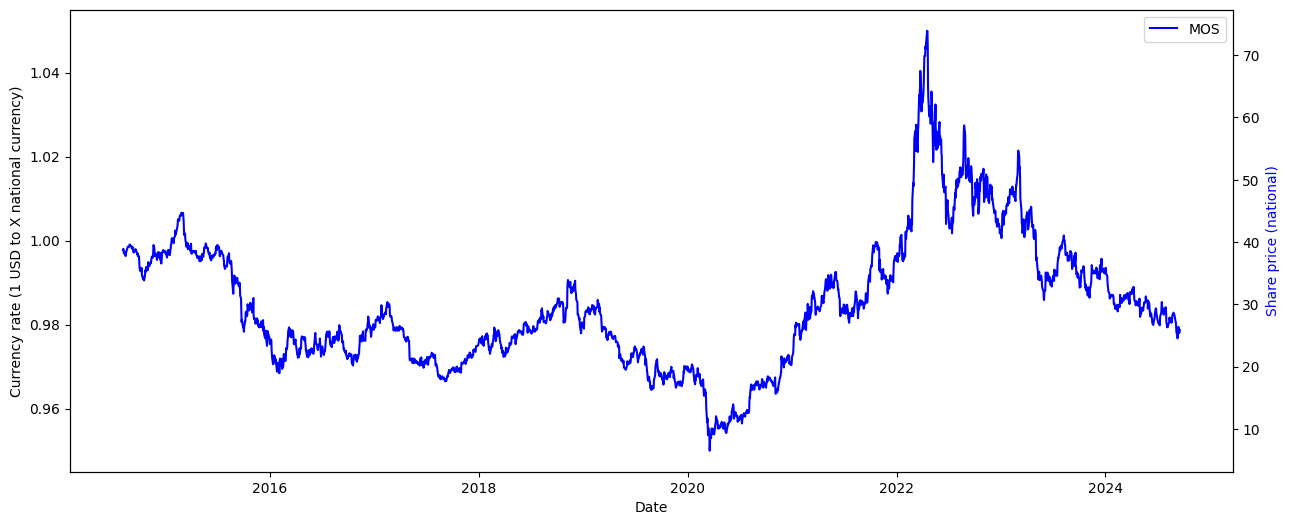

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

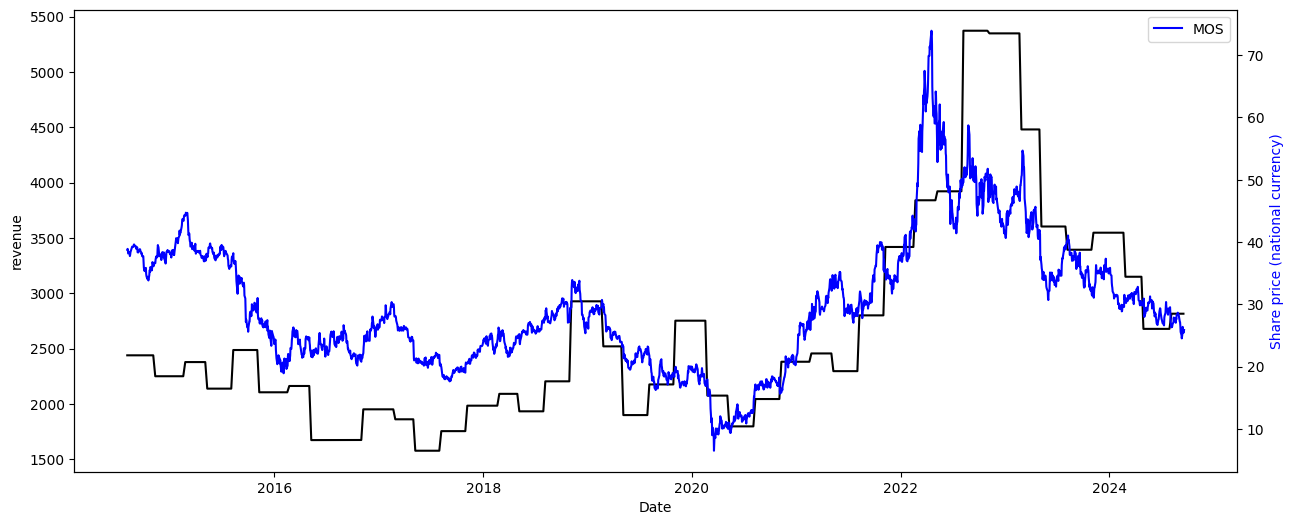

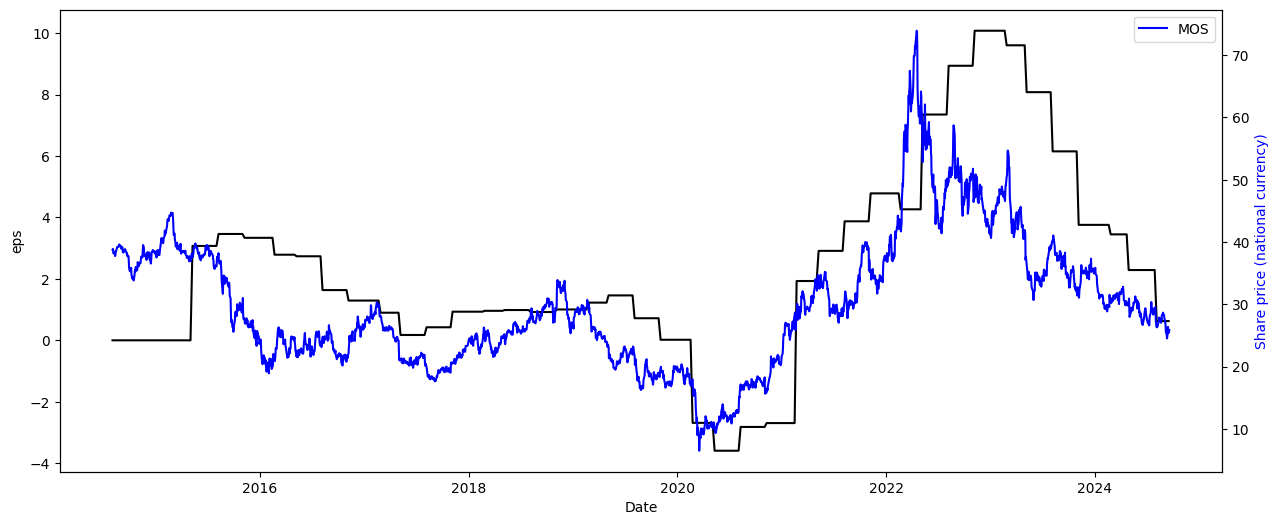

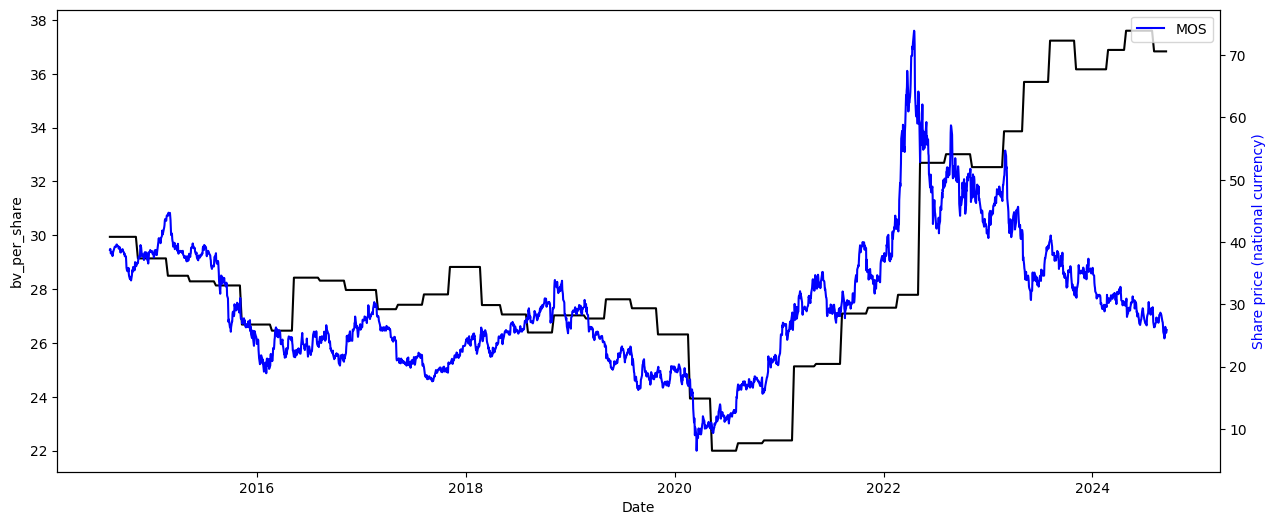

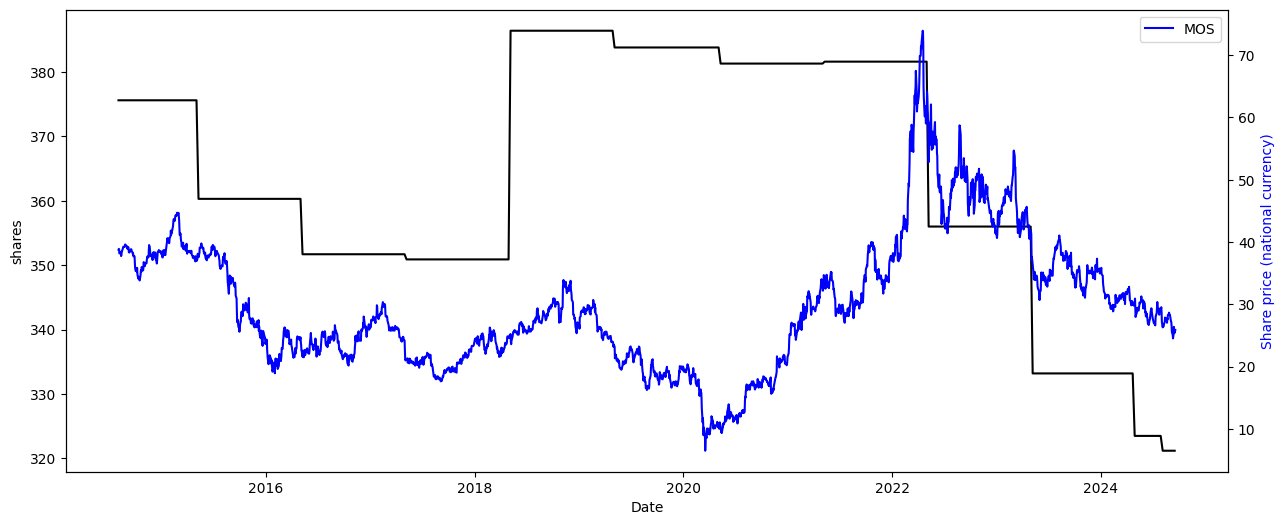

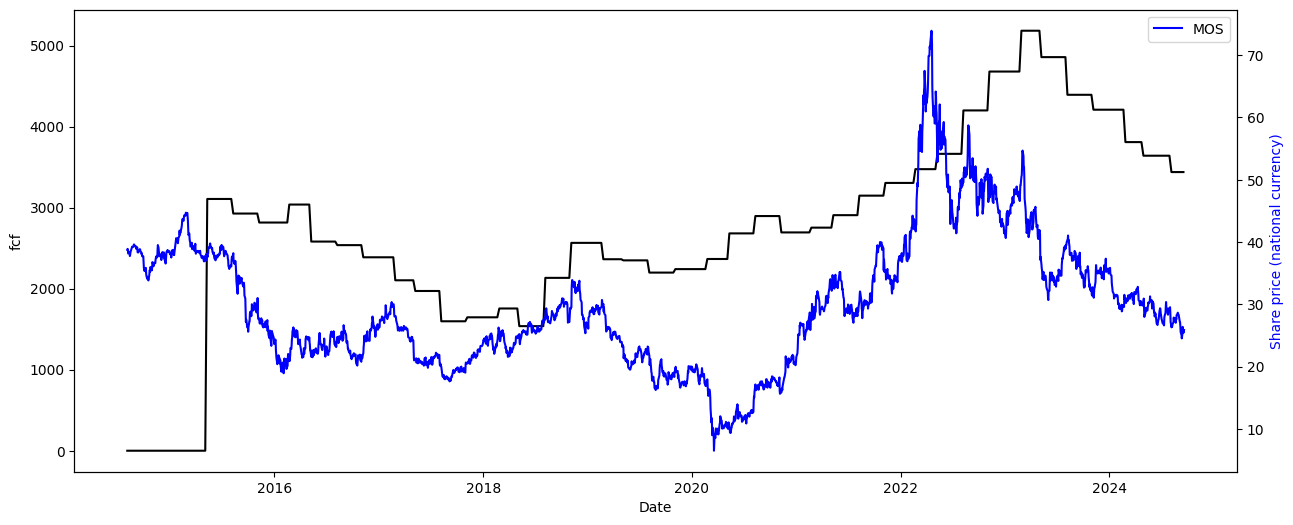

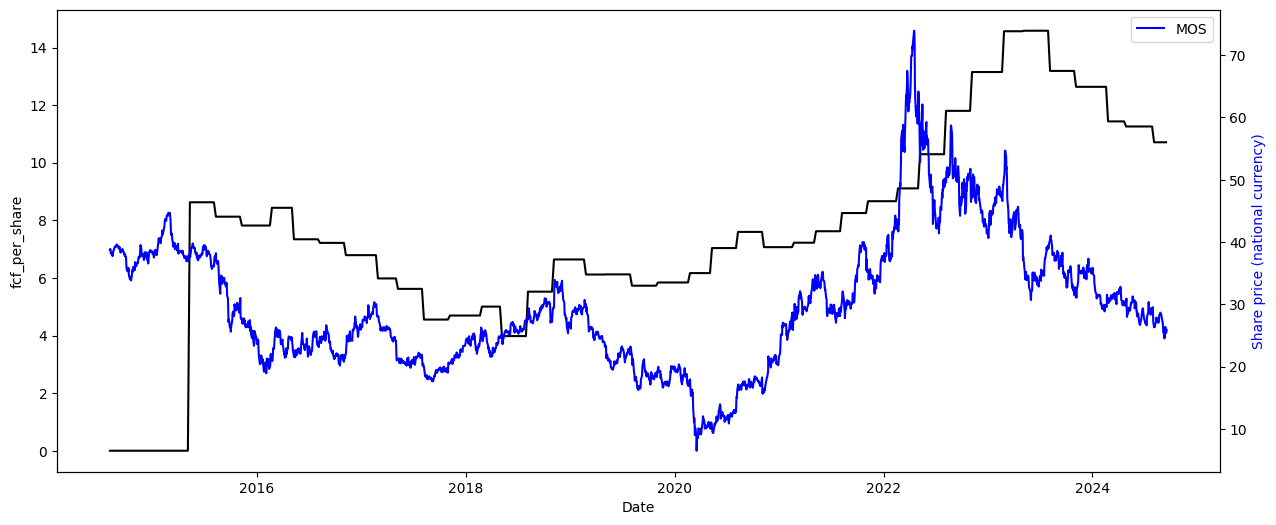

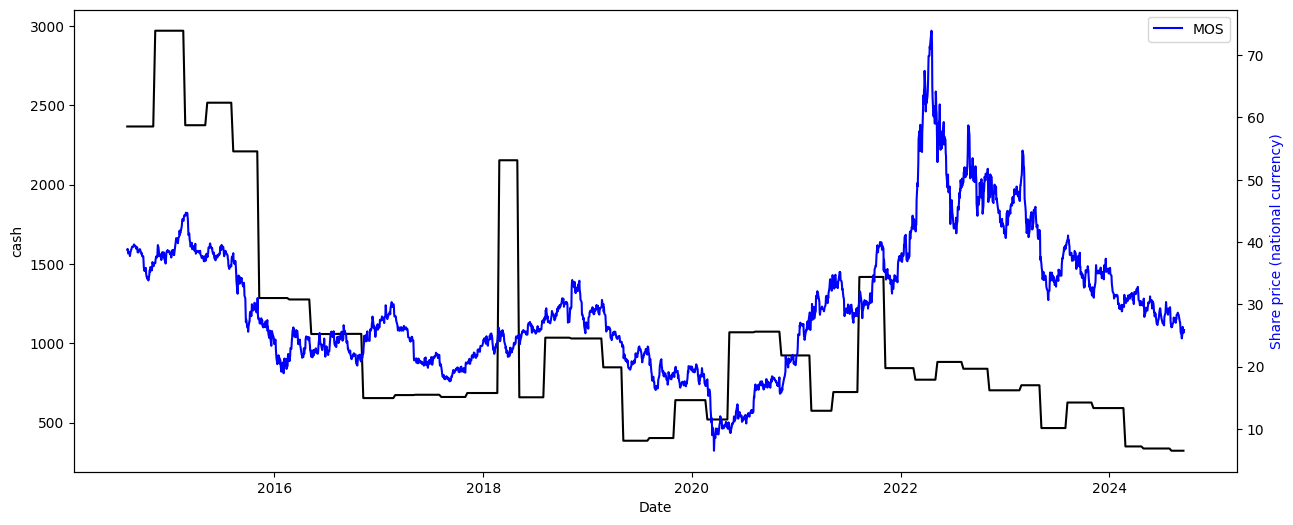

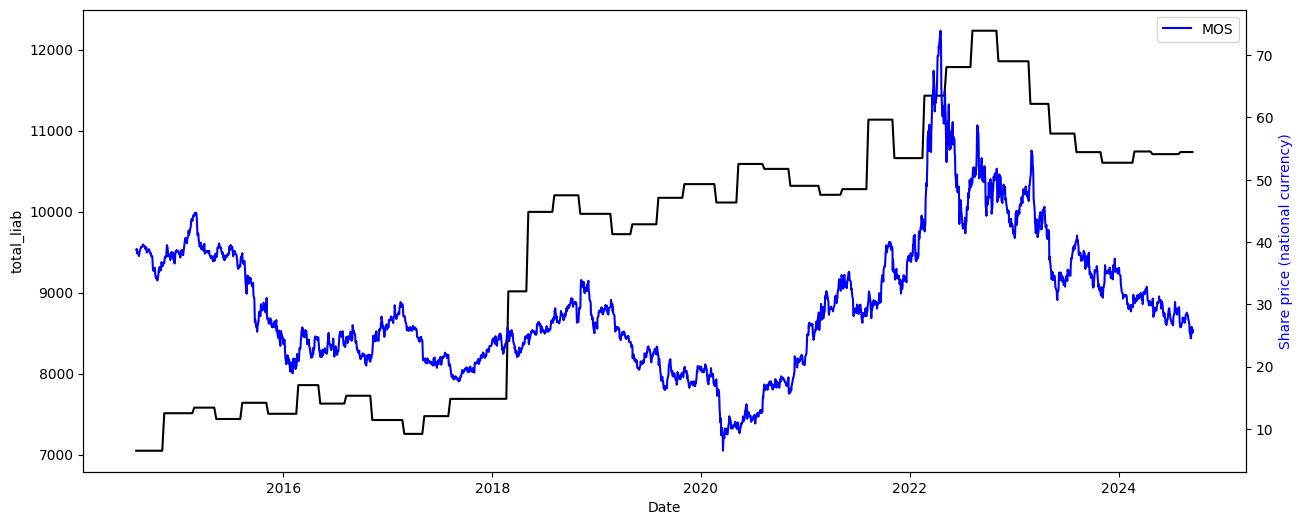

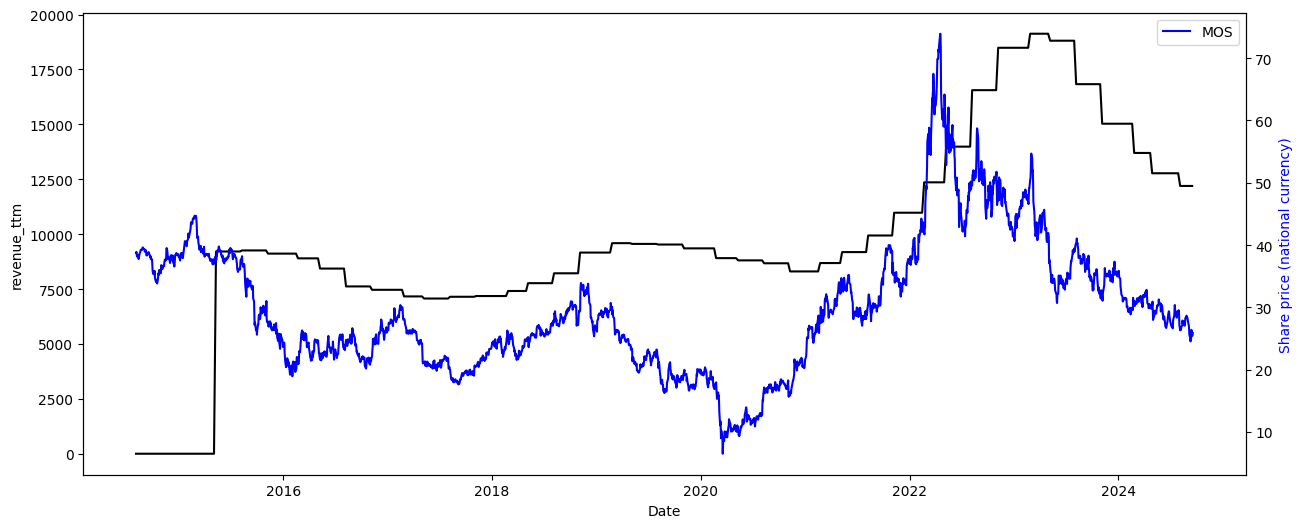

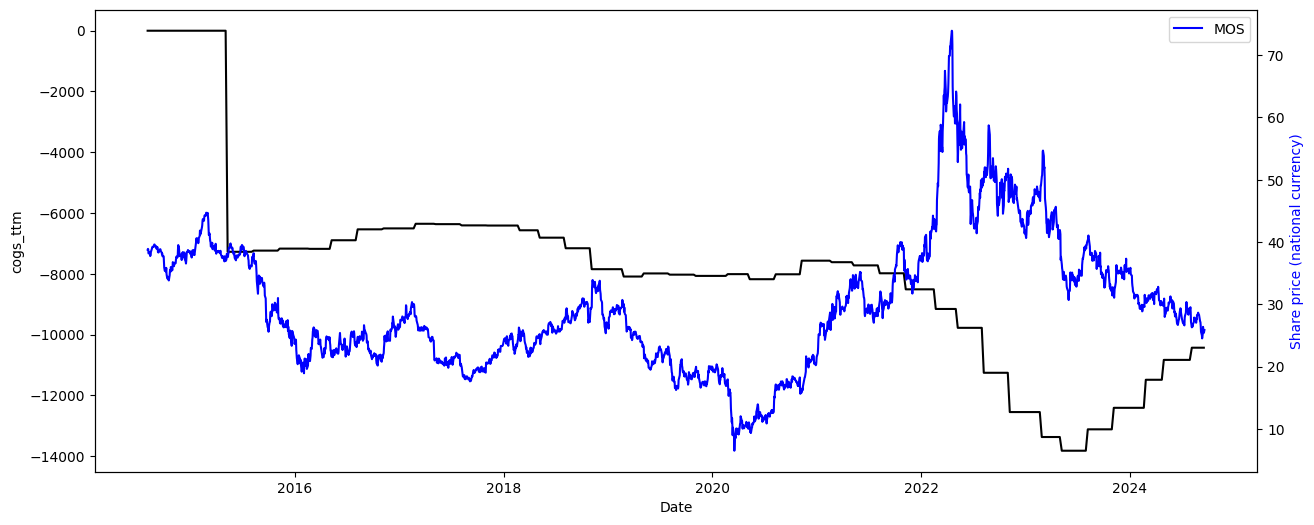

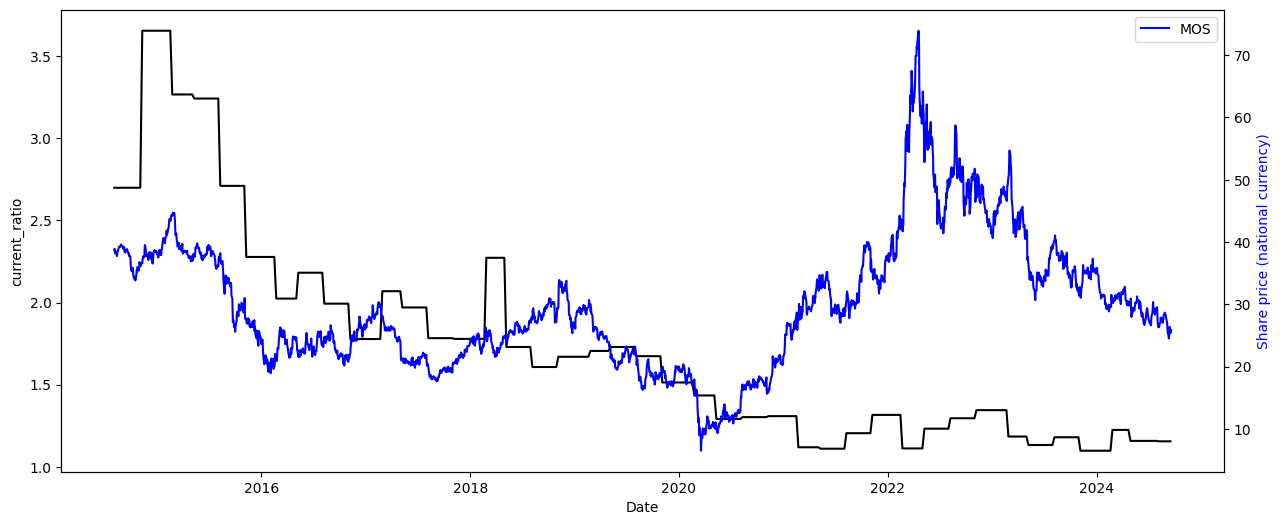

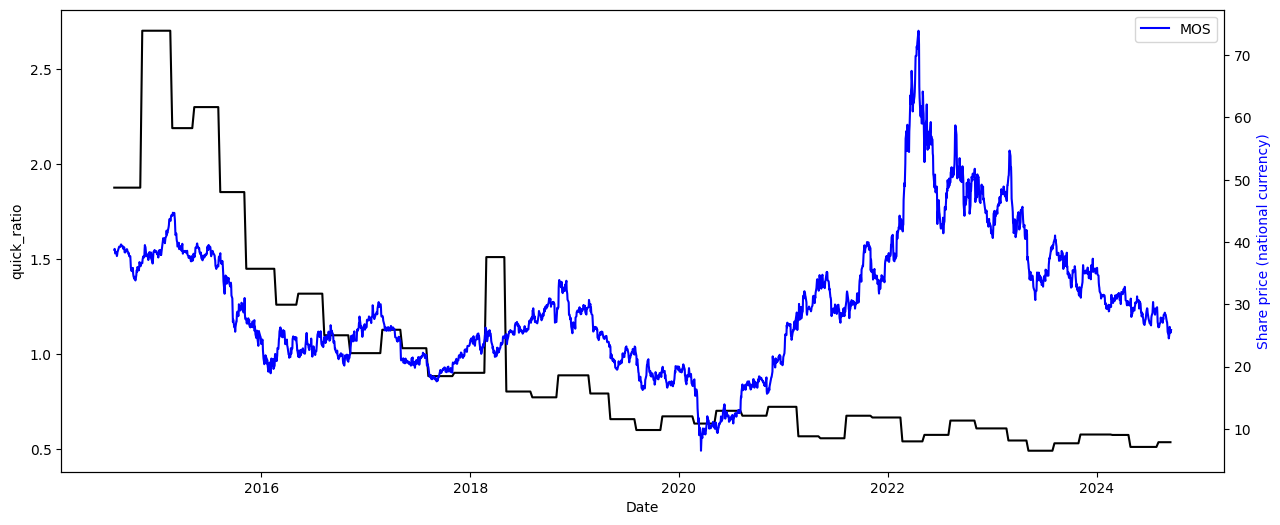

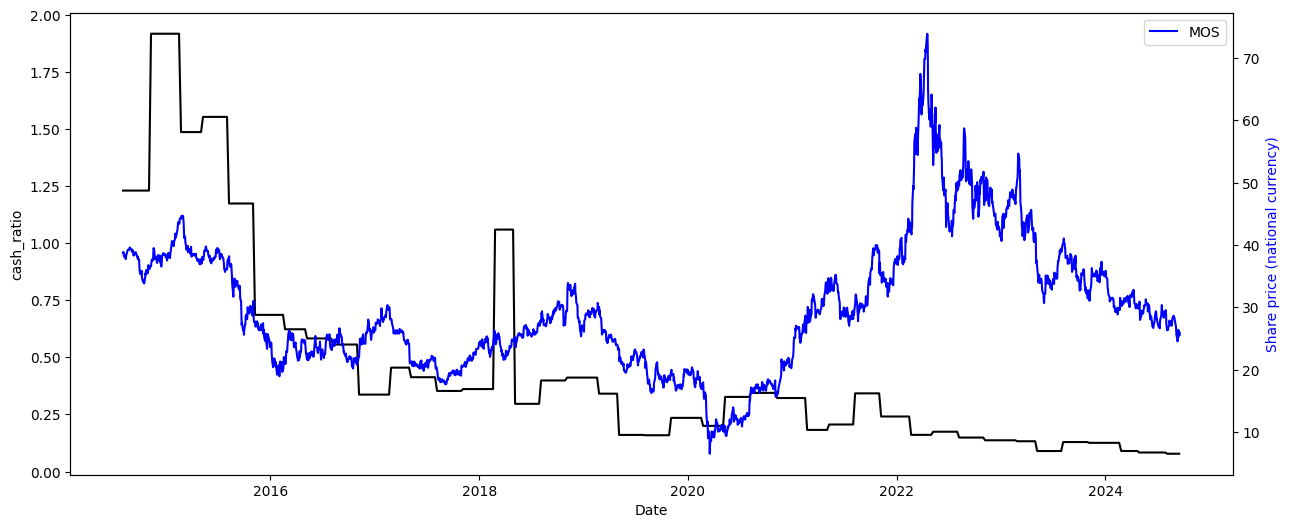

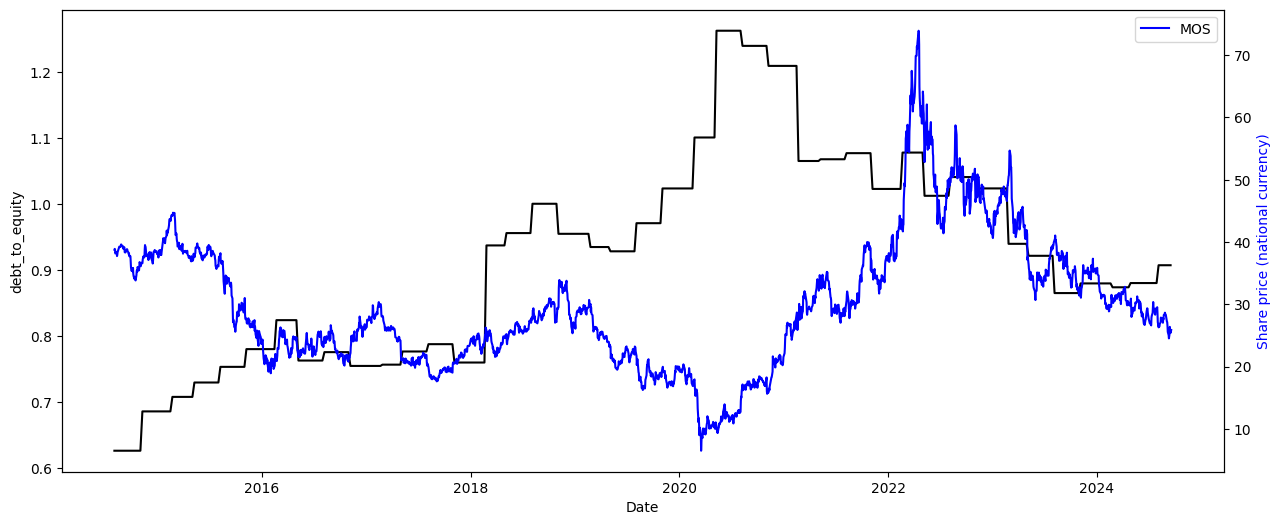

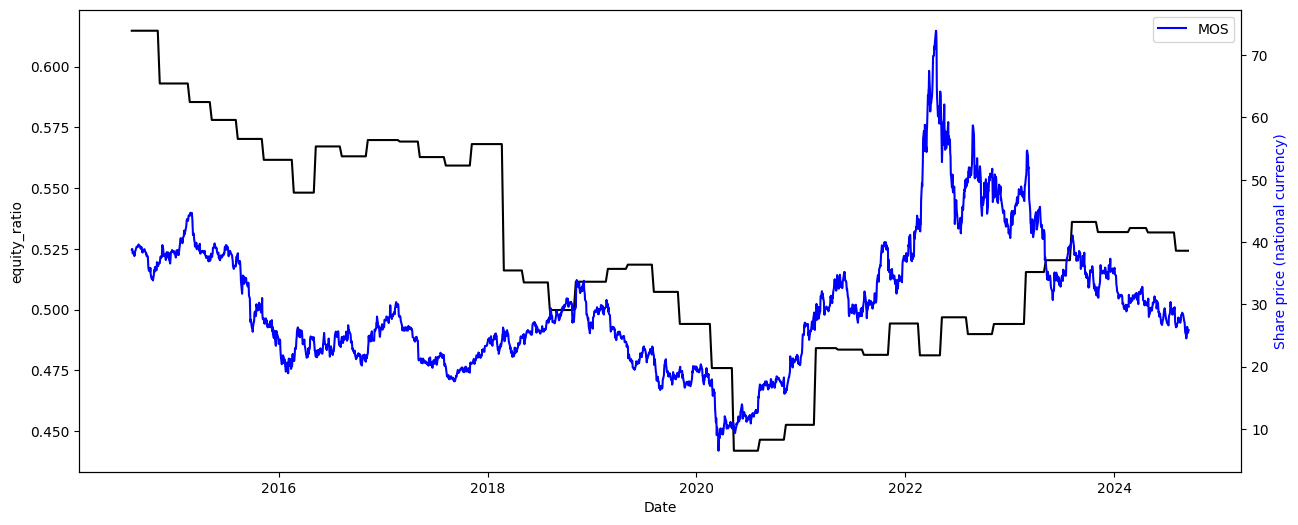

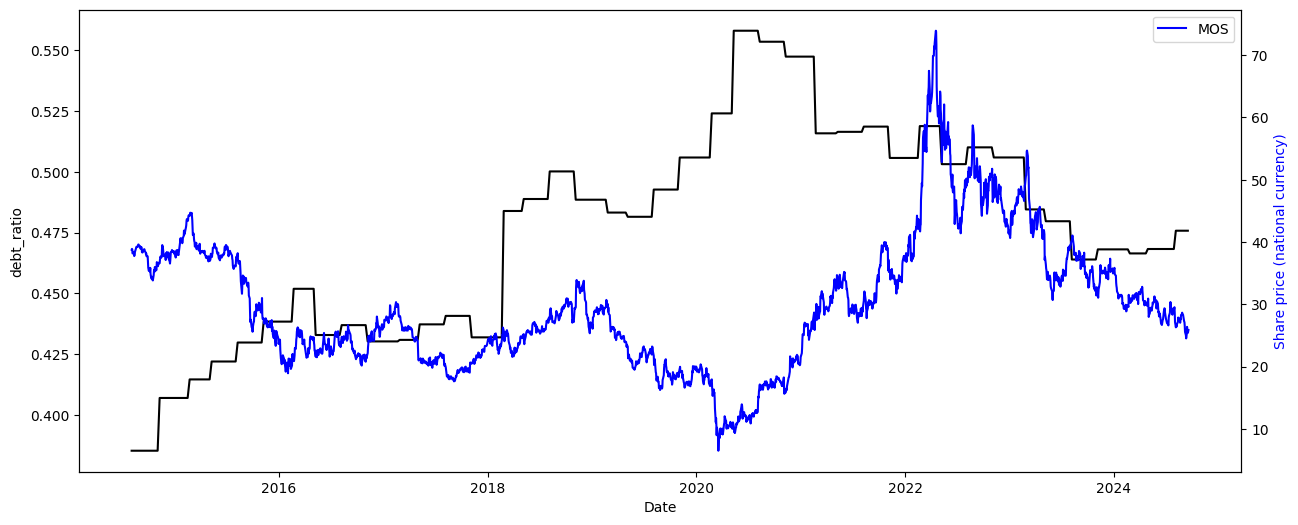

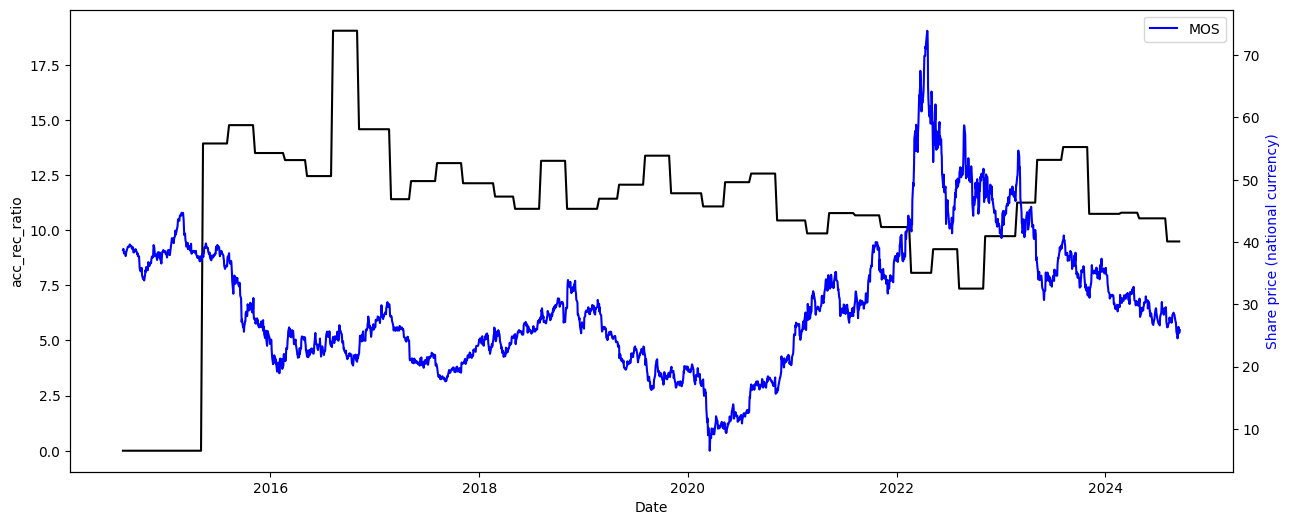

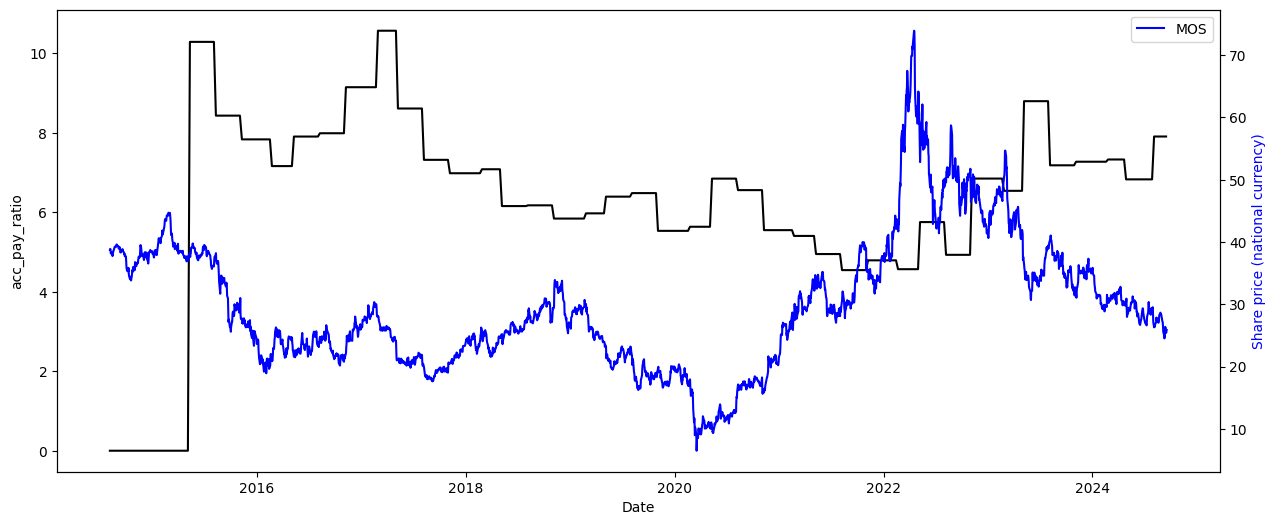

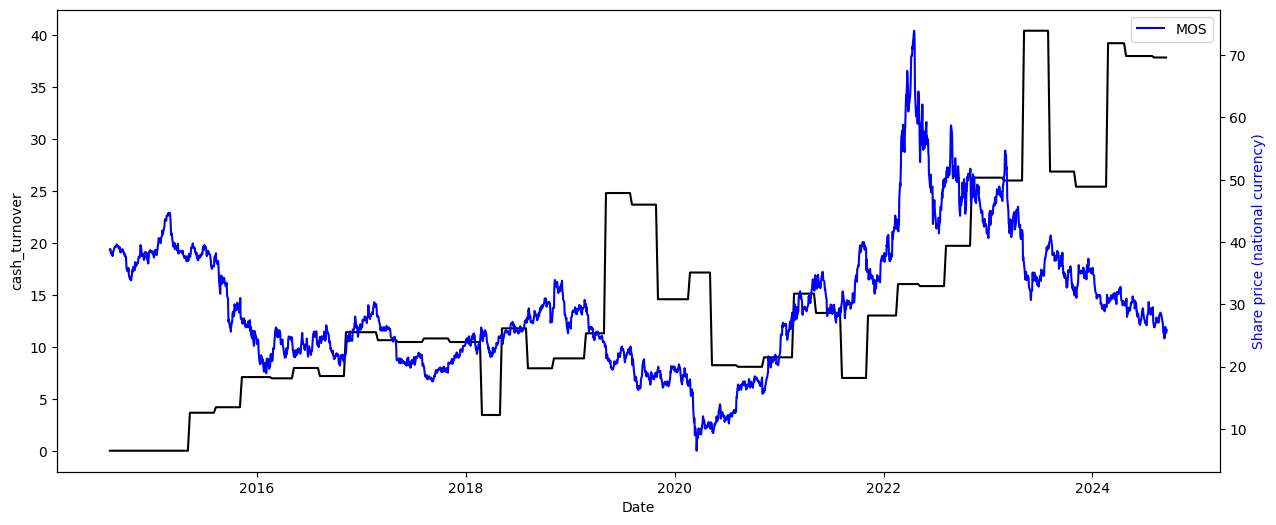

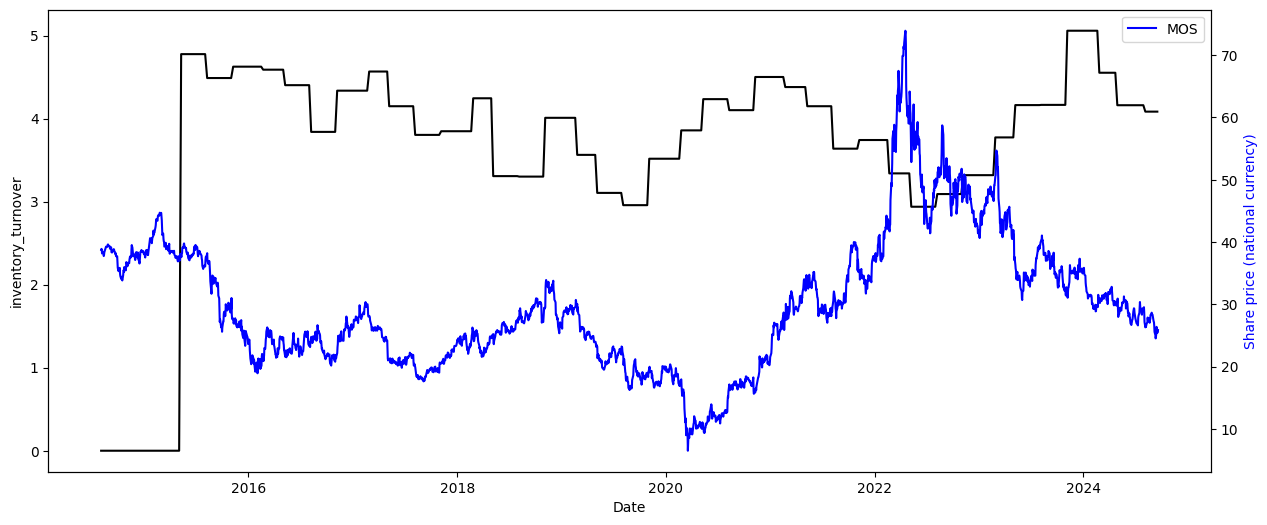

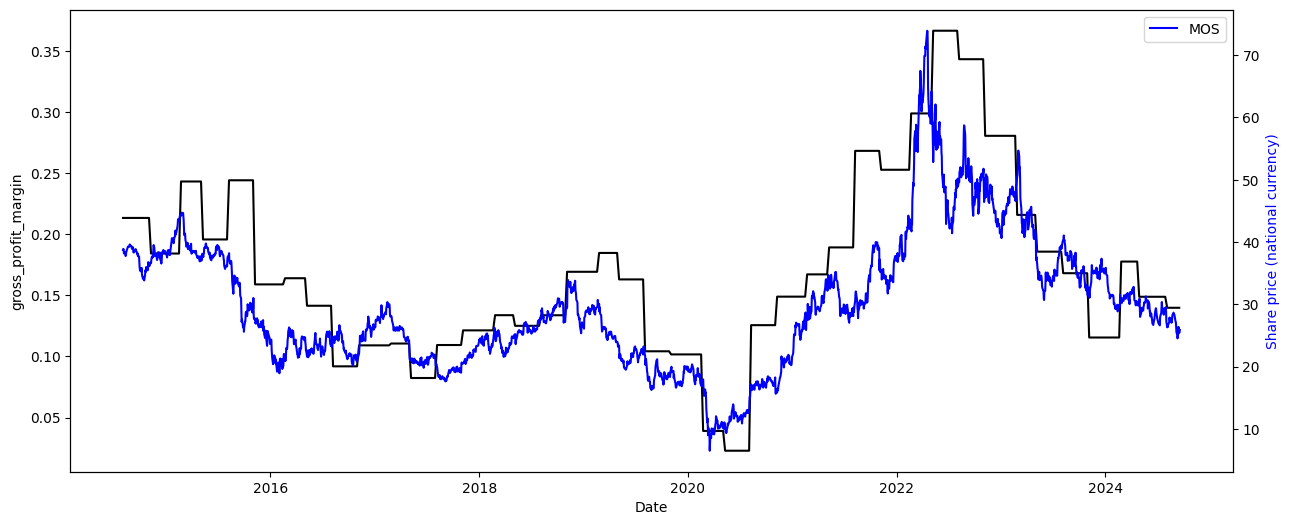

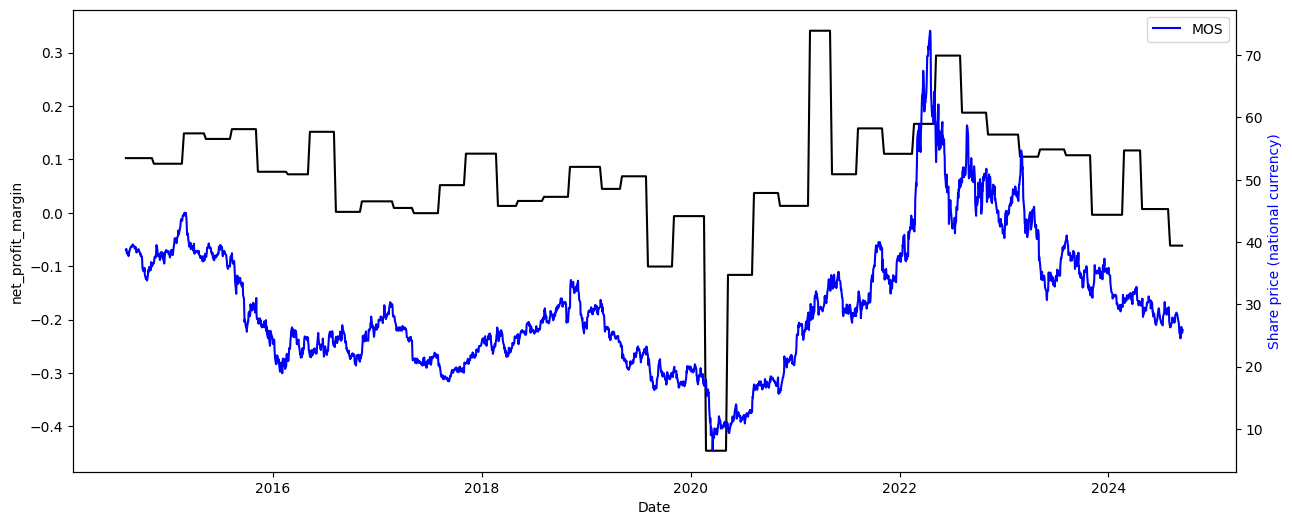

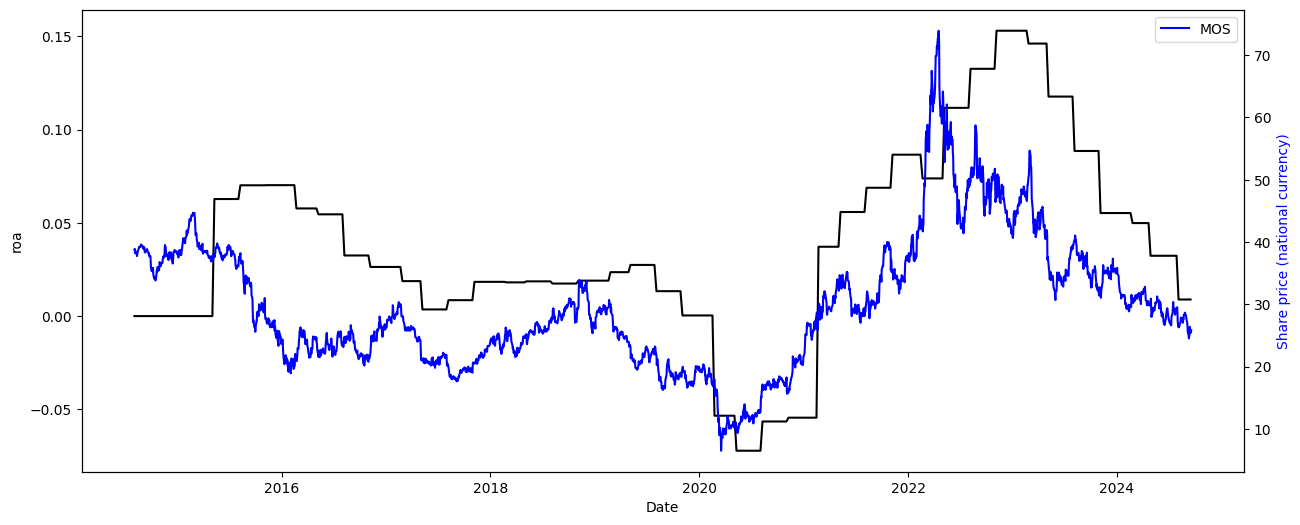

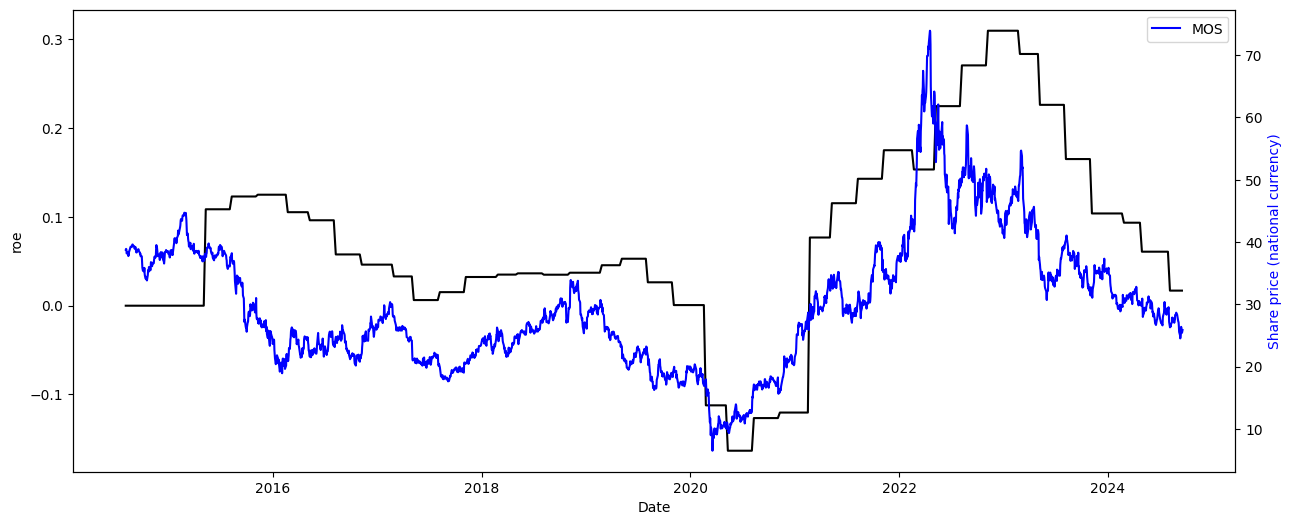

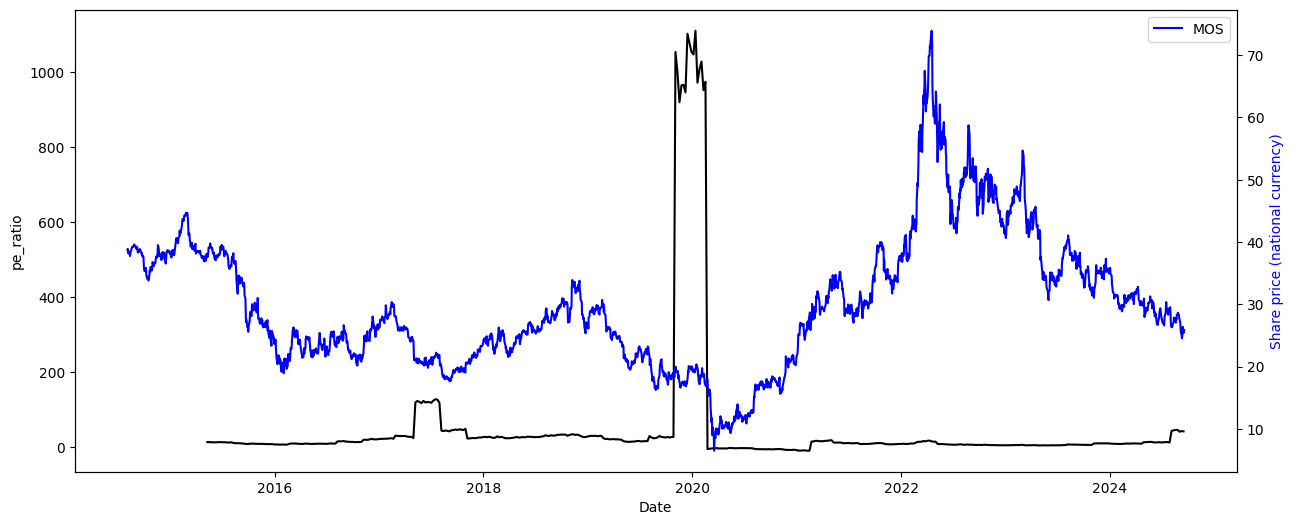

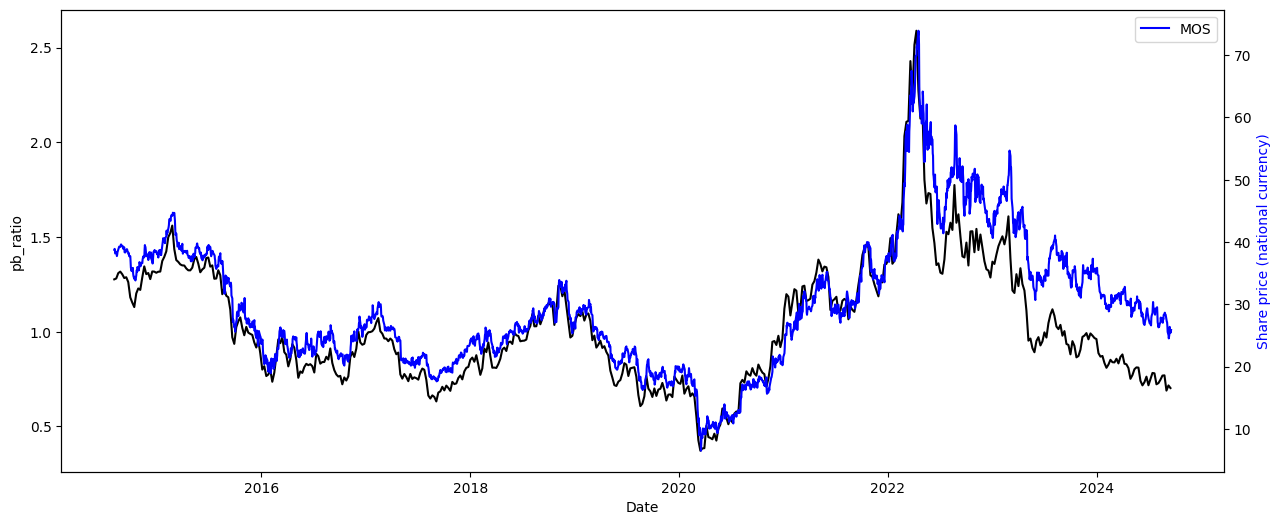

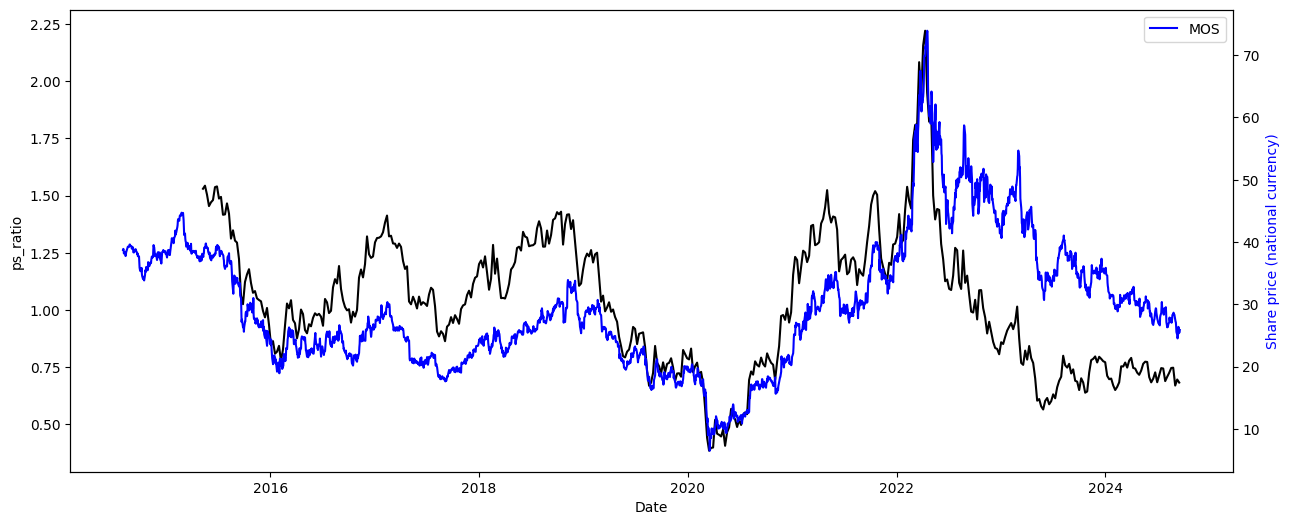

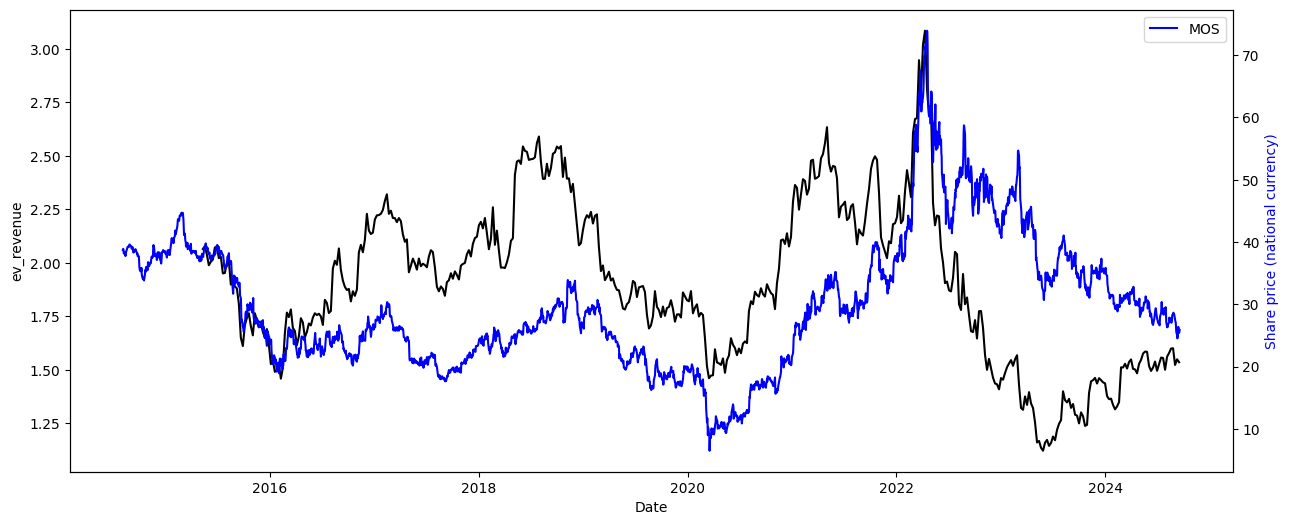

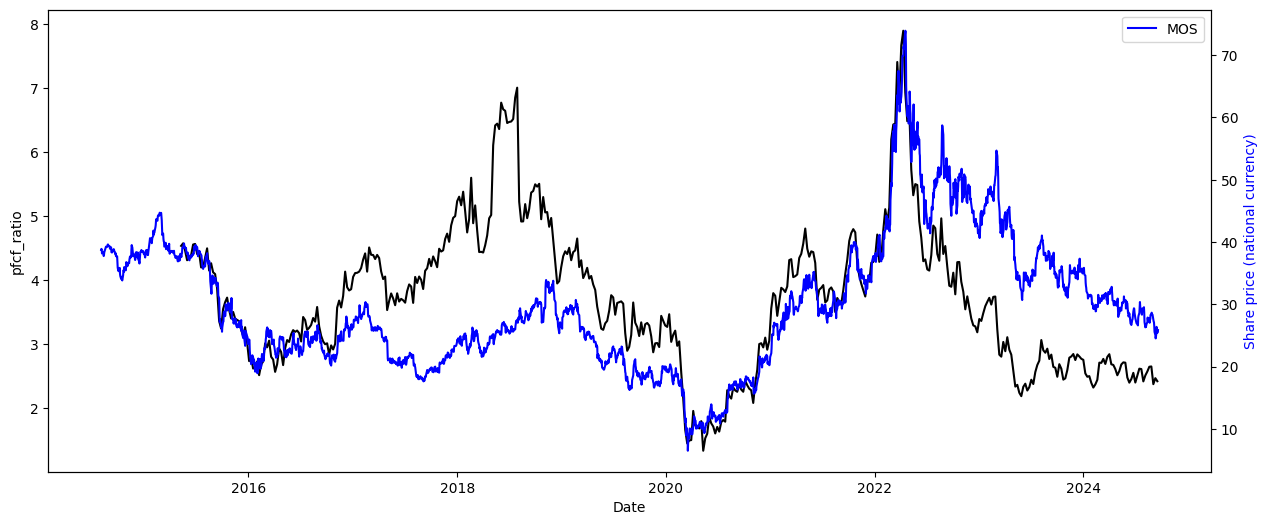

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

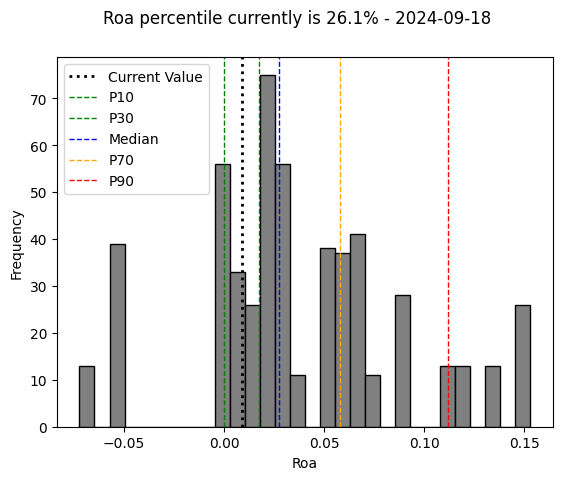

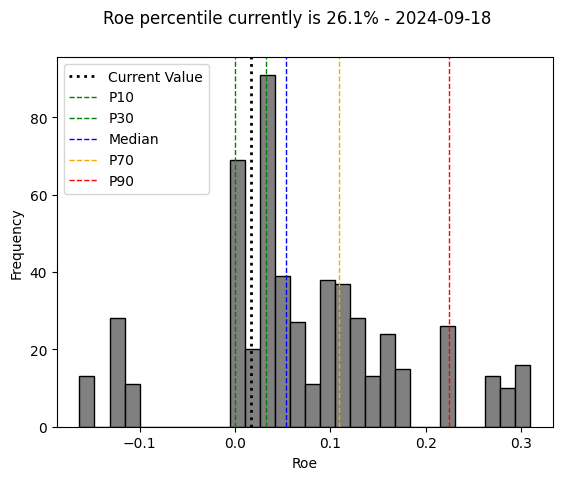

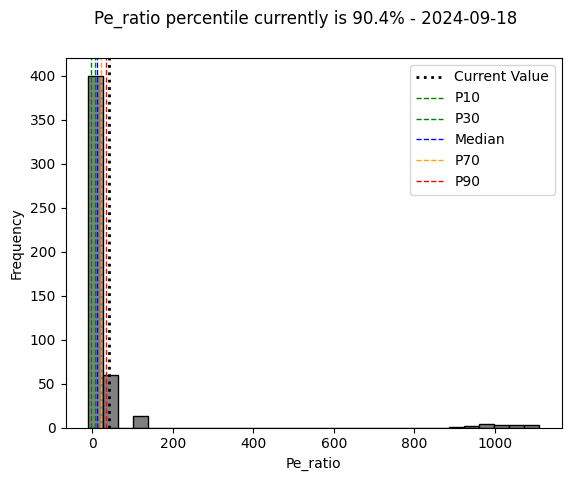

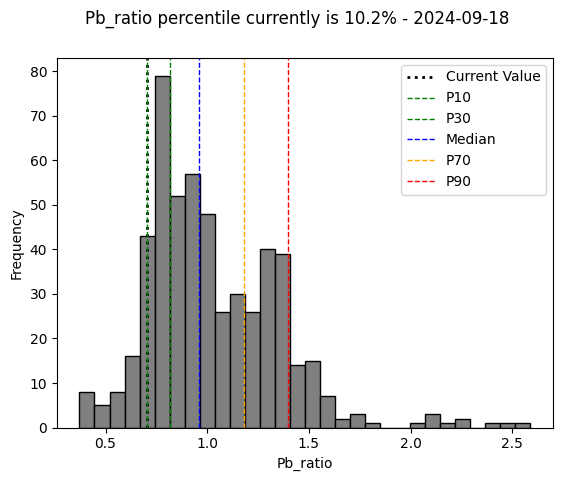

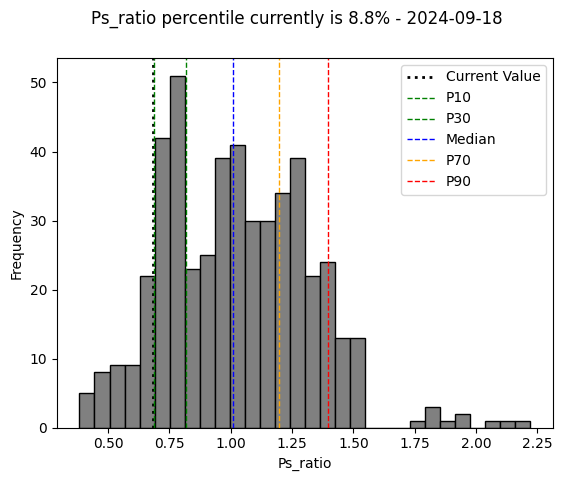

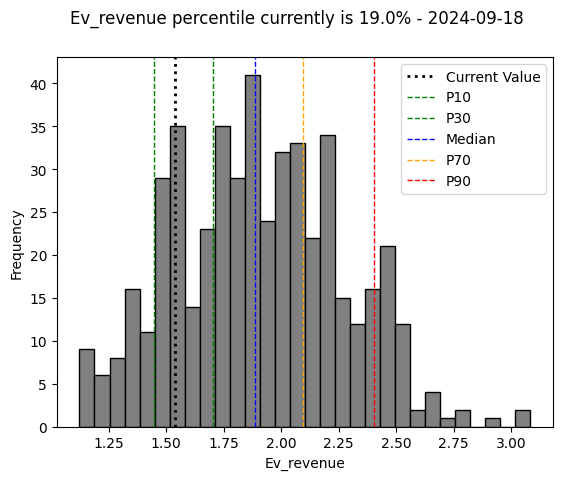

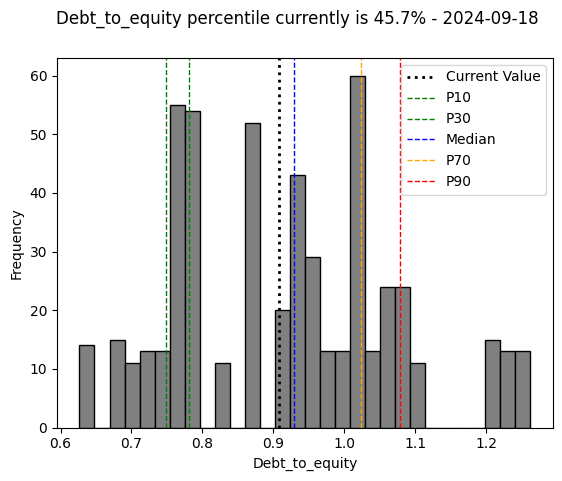

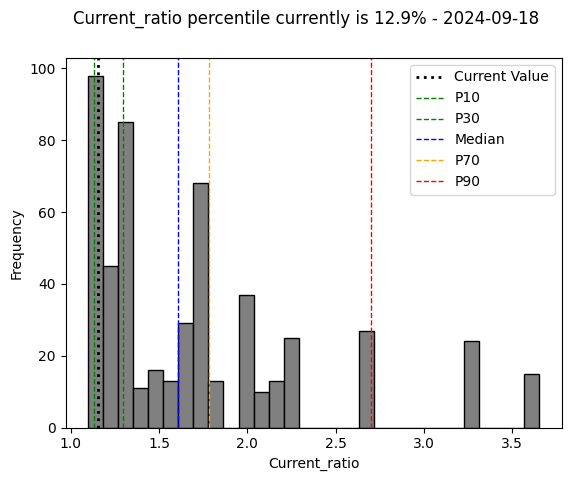

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.998095,-0.158003,0.530336,0.198472,-0.226007,-0.141111,-0.189504
roe,0.998095,1.000000,-0.145115,0.548827,0.216445,-0.194838,-0.131667,-0.199073
pe_ratio,-0.158003,-0.145115,1.000000,-0.187479,-0.143510,-0.024972,0.062043,-0.007900
pb_ratio,0.530336,0.548827,-0.187479,1.000000,0.731098,0.436431,0.021836,0.075375
ps_ratio,0.198472,0.216445,-0.143510,0.731098,1.000000,0.864416,-0.113391,0.252760
ev_revenue,-0.226007,-0.194838,-0.024972,0.436431,0.864416,1.000000,0.143893,0.103543
debt_to_equity,-0.141111,-0.131667,0.062043,0.021836,-0.113391,0.143893,1.000000,-0.703904
current_ratio,-0.189504,-0.199073,-0.007900,0.075375,0.252760,0.103543,-0.703904,1.000000


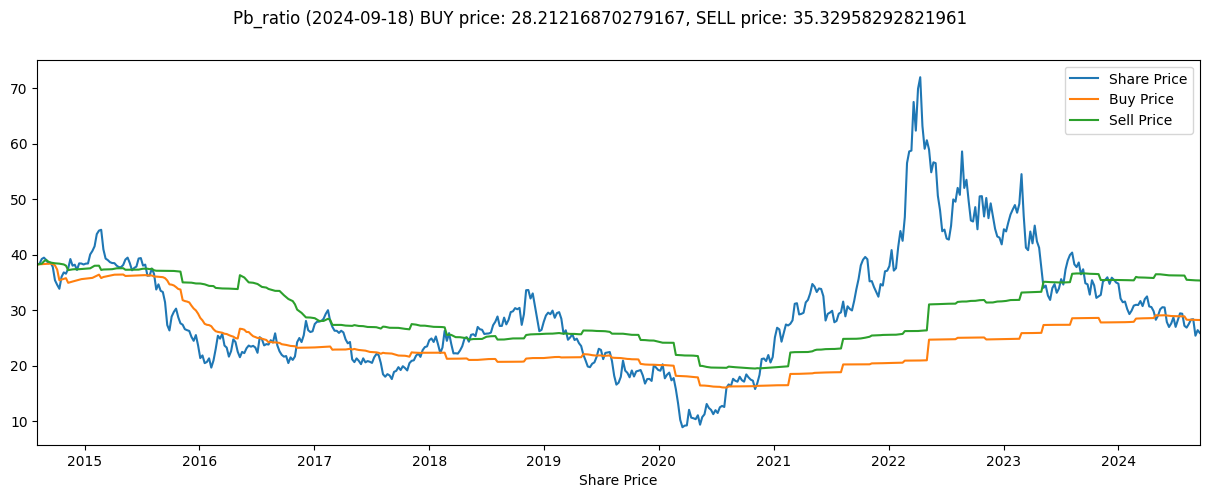

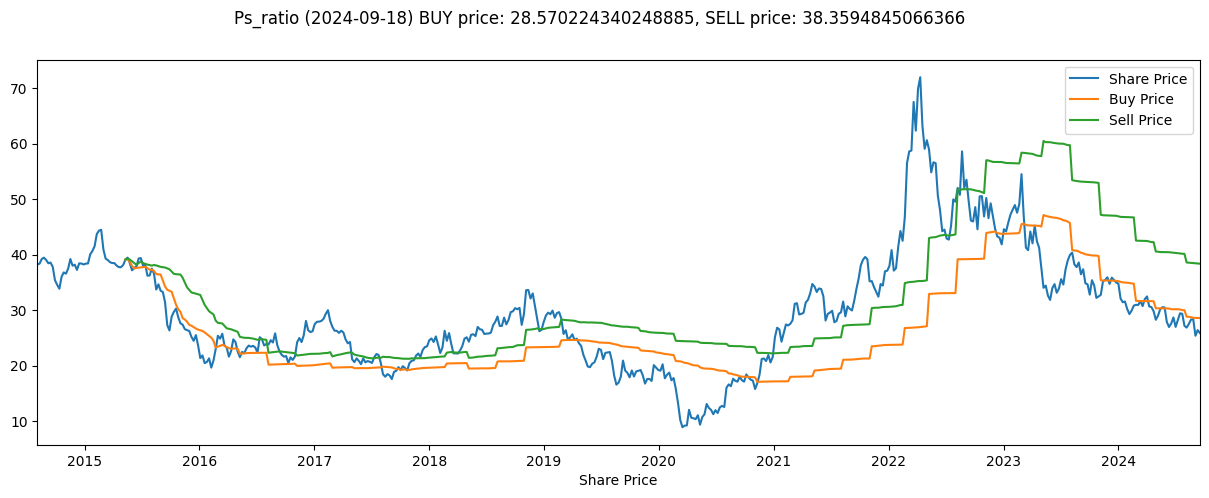

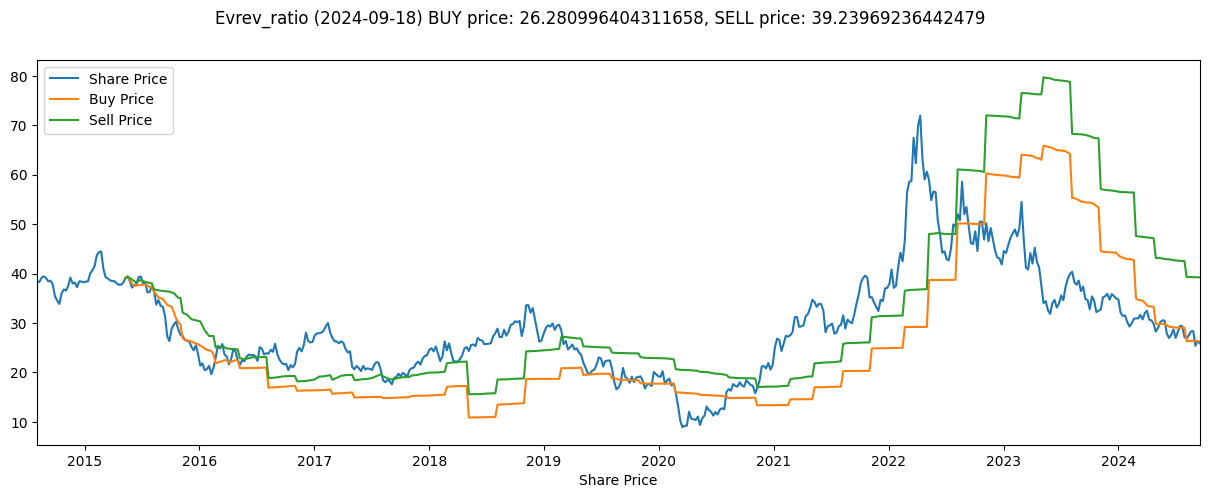

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)